## Google Analytics Reports

#### Tutorial on Install Google API Client

This notebook takes you through connecting with the Google Analytics Reporting API. Pulling the data and converting into table format, then visualising the result on a chart. 

##### Walkthrough to connect to the API:
1. Google Developer: https://developers.google.com/analytics/devguides/reporting/core/v4/quickstart/service-py
2. Other Walkthrough: https://www.jcchouinard.com/google-analytics-api-using-python/

##### Required Installations:
- conda install -c conda-forge google-api-python-client
- pip install --upgrade google-api-python-client
- pip3 install --upgrade oauth2client

In [225]:
# Load Libraries
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
import httplib2
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")

In [226]:
# Load keys and ids
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'client_secrets.json' # Enable Google Aanalytics Reporting API and Generate key 
VIEW_ID = 'XXXXXXX' #Go to Google Analytics > Admin > View > View Settings and copy the View ID.

#### Functions to pull report data from API

In [242]:
def initialize_analyticsreporting():
    """Initializes an Analytics Reporting API V4 service object.

    Returns:
    An authorized Analytics Reporting API V4 service object.
    """
    credentials = ServiceAccountCredentials.from_json_keyfile_name(
      KEY_FILE_LOCATION, SCOPES)

    # Build the service object.
    analytics = build('analyticsreporting', 'v4', credentials=credentials)

    return analytics


In [243]:
def get_report(analytics,request):
    """Queries the Analytics Reporting API V4.

    Args:
    analytics: An authorized Analytics Reporting API V4 service object.
    Returns:
    The Analytics Reporting API V4 response.
    """
    return analytics.reports().batchGet(
      body={
        'reportRequests': [
        request
        ]
      }
    ).execute()

In [244]:
def main(request):
    analytics = initialize_analyticsreporting()
    response = get_report(analytics,request)
    return response


#### Parsing the response into a table

In [245]:
def parseResponse(response):

    #Create two empty lists that will hold our dimensions and values
    dim = []
    val = []

    #Extract Data
    for report in response.get('reports', []):

        columnHeader = report.get('columnHeader', {})
        dimensionHeaders = columnHeader.get('dimensions', [])
        metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
        rows = report.get('data', {}).get('rows', [])

        for row in rows:

            dimensions = row.get('dimensions', [])
            dateRangeValues = row.get('metrics', [])

            for header, dimension in zip(dimensionHeaders, dimensions):
                dim.append(dimension)

            for i, values in enumerate(dateRangeValues):
                value = values.get('values')
                val.append(value)                    
    return dim, val


In [454]:
#### Faking the function to pulling in dummy data = hidden

def main(request):
    return request

def parseResponse(reponse):
    dim = []
    val = []
    # open file and read the content in a list
    with open('data/data_'+str(reponse)+'_1.txt', 'r') as filehandle:
        for line in filehandle:
            temp = line[:-1]
            dim.append(temp)
            
    with open('data/data_'+str(reponse)+'_2.txt', 'r') as filehandle:
        for line in filehandle:
            temp = line[:-1]
            temp = temp.replace("[","").replace("]","").replace("'","")
            #temp = temp.replace("'","")
            temp = temp.split(',')
            temp_list = []
            for e in temp:
                temp_list.append(e)
            val.append(temp_list)
            
    return dim,val

#### Pulling and Visualising the Data 

Google Analytics Metric and Dimension Explorer: https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/

##### 1. How many organic visits do we have over time?

In the filter we retrieve only sessions that came from a direct source

In [429]:
# Run Functions
request = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2019-06-01'}],
                'metrics': [{'expression': 'ga:sessions'}], 
                'dimensions': [{"name":"ga:date"}], 
                'filtersExpression':'ga:Source=~direct', # Filter direct traffic only 
                'orderBys': [{"fieldName": "ga:date", "sortOrder": "ASCENDING"}], 
                'pageSize': 100
            }

In [430]:
request = 1 # hidden

In [431]:
response = main(request) # Pull API data into dictionary
parsed_data = parseResponse(response) # Parse data into Lists

In [432]:
# Create a DataFrame with the Data
df = pd.concat([pd.DataFrame(parsed_data[0]),pd.DataFrame(parsed_data[1])],axis=1)
df.columns = ['Date','Sessions']

In [433]:
# View the data
df.head()

,Date,Sessions
0,20190101,3
1,20190102,10
2,20190103,13
3,20190104,8
4,20190105,9


In [434]:
# Convert Date column to date type
df2 = df.copy()
df2['Date'] = df2['Date'].str.slice(0,4)+'-'+df2['Date'].str.slice(4,6)+'-'+df2['Date'].str.slice(6,8)
df2['Date'] = pd.to_datetime(df2['Date'])

# Convert metrics to numeric
df2['Sessions'] = df2['Sessions'].astype('float64')

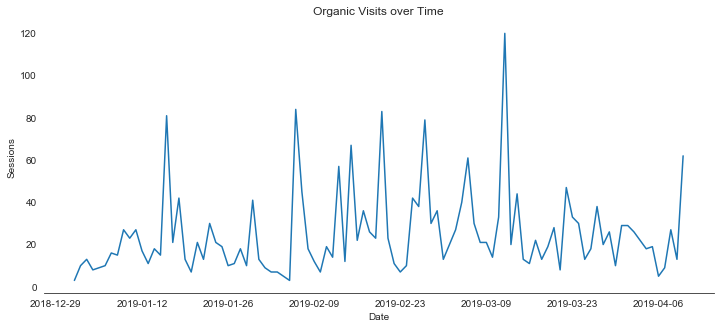

In [435]:
# Chart the data
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(data=df2, x='Date',y='Sessions')
sns.despine(left=True)
ax.set_title('Organic Visits over Time');

##### 2. From which sources does most of the traffic come from?

In [436]:
# Run Functions
request = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2019-06-01'}],
                'metrics': [{'expression': 'ga:sessions'},{'expression': 'ga:users'}], 
                'dimensions': [{"name":"ga:Source"}], 
                'orderBys': [{"fieldName": "ga:Sessions", "sortOrder": "DESCENDING"}], 
                'pageSize': 10
            }

In [437]:
request = 2 # hidden

In [438]:
response = main(request) # Pull API data into dictionary
parsed_data = parseResponse(response) # Parse data into Lists

In [439]:
# Create a DataFrame with the Data
df = pd.concat([pd.DataFrame(parsed_data[0]),pd.DataFrame(parsed_data[1])],axis=1)
df.columns = ['Source','Sessions','Users']

# View the data
df.head()

,Source,Sessions,Users
0,google,5353,4164
1,(direct),3511,2354
2,m.facebook.com,691,602
3,instagram.com,217,215
4,l.instagram.com,156,148


In [440]:
# Convert metrics to numeric
df2 = df.copy()
df2['Sessions'] = df2['Sessions'].astype('float64')
df2['Users'] = df2['Users'].astype('float64')

In [441]:
# Transform data
df3 = pd.melt(df2,id_vars="Source",var_name="Type",value_name="metric")
df3.head()

,Source,Type,metric
0,google,Sessions,5353.0
1,(direct),Sessions,3511.0
2,m.facebook.com,Sessions,691.0
3,instagram.com,Sessions,217.0
4,l.instagram.com,Sessions,156.0


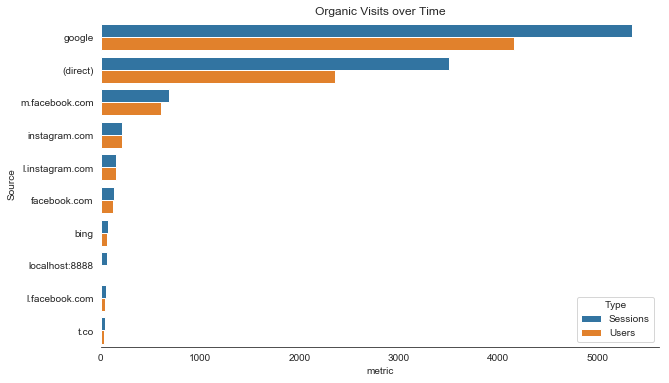

In [442]:
# Chart the data
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(data=df3, y='Source',x='metric',hue='Type')
sns.despine(left=True)
ax.set_title('Organic Visits over Time');

##### 3. What is the distribution of session duration?

In [445]:
# Run Functions
request = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2019-06-01'}],
                'metrics': [{'expression': 'ga:sessions'}], 
                'dimensions': [{"name":"ga:sessionDurationBucket"}], 
                #'orderBys': [{"fieldName": "ga:sessionDurationBucket", "sortOrder": "DESCENDING"}], 
                #'pageSize': 20
            }

In [446]:
request = 3 # hidden

In [447]:
response = main(request) # Pull API data into dictionary
parsed_data = parseResponse(response) # Parse data into Lists

In [448]:
# Create a DataFrame with the Data
df = pd.concat([pd.DataFrame(parsed_data[0]),pd.DataFrame(parsed_data[1])],axis=1)
df.columns = ['Session Duration','Count']

# View the data
df.head()

,Session Duration,Count
0,0,6608
1,1,10
2,10,22
3,100,12
4,1000,1


In [449]:
# Convert metrics to numeric
df2 = df.copy()
df2['Session Duration'] = df2['Session Duration'].astype('float64')
df2['Count'] = df2['Count'].astype('float64')

df2 = df2.loc[df2['Session Duration'] != 0,:] # remove session duration = 0
df2 = df2.sort_values('Session Duration').\
    reset_index().\
    drop('index',axis=1) # sort values by session duration

In [450]:
# Remove session durations with less than 10 count
df3 = df2.loc[(df2.Count > 10),:] 

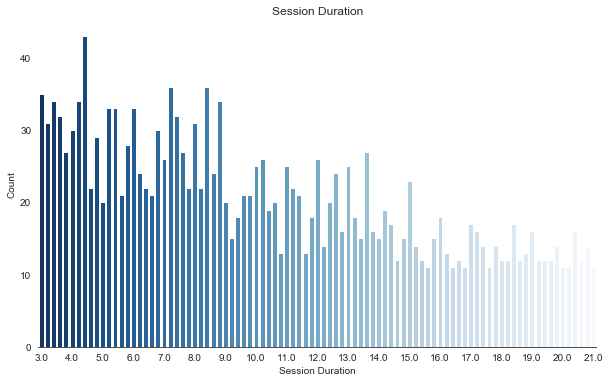

In [451]:
# Chart the data
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(data=df3, y='Count',x='Session Duration',
                palette = 'Blues_r')
sns.despine(left=True)
ax.set_title('Session Duration');
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [452]:
# with open('data_1_1.txt', 'w') as filehandle:
#     for listitem in parsed_data[0]:
#         filehandle.write('%s\n' % listitem)
# with open('data_1_2.txt', 'w') as filehandle:
#     for listitem in parsed_data[1]:
#         filehandle.write('%s\n' % listitem)